<a href="https://colab.research.google.com/github/Vidzhel/data-analysis/blob/main/Lab_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Побудувати модель для прогнозу ціни криптовалюти ефір( ETH )

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error
from datetime import datetime

In [2]:
prices_df = pd.read_csv('https://raw.githubusercontent.com/Vidzhel/data-analysis/main/historical_data.csv', sep=',')
blockchain_df = pd.read_csv('https://raw.githubusercontent.com/Vidzhel/data-analysis/main/blockchain_data.csv', sep=',')
twitter_sentiments = pd.read_csv('https://raw.githubusercontent.com/Vidzhel/data-analysis/main/twitter_sentiments.csv', sep=',')

In [3]:
prices_df.head()

,close_time,trading_pair,open,close,high,low,volume,trades_amount
0,1678579200,ETHUSDT,1459.68,1471.97,1478.07,1458.38,24802.584,36371590
1,1678575600,ETHUSDT,1465.04,1459.69,1468.92,1457.38,19666.553,28770608
2,1678572000,ETHUSDT,1466.20,1465.03,1469.19,1457.51,33629.670,49195664
3,1678568400,ETHUSDT,1449.22,1466.21,1470.00,1449.21,58938.742,86078175
4,1678564800,ETHUSDT,1448.59,1449.22,1452.19,1443.87,27683.530,40074966


In [4]:
blockchain_df.head()

,time,ticker,blockchain_type,min_value,max_value,average_amount,average_fee,average_gas_price,gas_used,difficulty,transaction_amount
0,1678579200,ETH,ETH,0.0,1.331496e+11,1.591579e+09,0.000278,28.301594,1.430367e+07,58750003716598360000000,110
1,1678575600,ETH,ETH,0.0,7.618358e+09,2.762103e+08,0.000243,32.083941,9.174313e+06,58750003716598360000000,91
2,1678572000,ETH,ETH,0.0,5.579591e+10,9.390270e+08,0.000339,48.625681,1.457290e+07,58750003716598360000000,129
3,1678568400,ETH,ETH,0.0,7.007760e+11,3.214554e+09,0.000406,50.012074,1.658236e+07,58750003716598360000000,133
4,1678564800,ETH,ETH,0.0,3.158048e+10,5.741246e+08,0.000250,41.589516,1.321338e+07,58750003716598360000000,113


In [5]:
twitter_sentiments.head()

,time,keyword,positive,negative,neutral
0,1678579200,#ETH,19,5,72
1,1678575600,#ETH,16,4,79
2,1678572000,#ETH,15,2,111
3,1678568400,#ETH,29,4,111
4,1678564800,#ETH,33,4,107


In [7]:
def line_plot(train, test, label1 = None, label2 = None, title='', lw=2):
  fig, ax = plt.subplots(1, figsize=(13, 7))
  if 'time' in train.keys():
    ax.plot(train['time'].apply(lambda x: datetime.fromtimestamp(x)), train['close'], label=label1, linewidth=lw)
    ax.plot(test['time'].apply(lambda x: datetime.fromtimestamp(x)), test['close'], label=label2, linewidth=lw)
  else:
    ax.plot(train['close'], label = label1, linewidth = lw)
    ax.plot(test['close'], label = label2, linewidth = lw)
    ax.set_ylabel('Ціна [USD]', fontsize = 14)
    ax.set_title(title, fontsize = 16)
    ax.legend(loc='best', fontsize = 16)
    plt.show()

def plot_result(actual, predicted):
  fig, ax = plt.subplots(1, figsize=(13, 7))
  ax.plot(actual, label = 'actual', linewidth = 1)
  for key in predicted.keys():
    ax.plot(predicted[key], label = key, linewidth = 1)
    ax.set_ylabel('Ціна [USD]', fontsize = 14)
    ax.legend(loc='best', fontsize = 16)
    plt.show()

In [8]:
merged_df = pd.merge(pd.merge(blockchain_df, prices_df, left_on = 'time',right_on = 'close_time'), twitter_sentiments, on = 'time')
merged_df.sort_values(by=["time"], inplace = True)

In [9]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1999 entries, 1998 to 0
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   time                1999 non-null   int64  
 1   ticker              1999 non-null   object 
 2   blockchain_type     1999 non-null   object 
 3   min_value           1999 non-null   float64
 4   max_value           1999 non-null   float64
 5   average_amount      1999 non-null   float64
 6   average_fee         1999 non-null   float64
 7   average_gas_price   1999 non-null   float64
 8   gas_used            1999 non-null   float64
 9   difficulty          1999 non-null   object 
 10  transaction_amount  1999 non-null   int64  
 11  close_time          1999 non-null   int64  
 12  trading_pair        1999 non-null   object 
 13  open                1999 non-null   float64
 14  close               1999 non-null   float64
 15  high                1999 non-null   float64
 16  low   

In [10]:
merged_df.head()

,time,ticker,blockchain_type,min_value,max_value,average_amount,average_fee,average_gas_price,gas_used,difficulty,...,open,close,high,low,volume,trades_amount,keyword,positive,negative,neutral
1998,1671382800,ETH,ETH,0.0,4.223955e+10,5.866898e+08,0.000223,16.193595,1.504390e+07,58750003716598360000000,...,1174.39,1177.62,1178.29,1173.76,5139.9775,6047430,#ETH,20,2,178
1997,1671386400,ETH,ETH,0.0,3.935660e+10,6.416365e+08,0.000242,18.271843,1.729403e+07,58750003716598360000000,...,1177.61,1178.32,1178.39,1175.84,5129.0380,6038929,#ETH,20,1,179
1996,1671390000,ETH,ETH,0.0,4.223942e+09,1.164573e+08,0.000220,17.700974,1.643561e+07,58750003716598360000000,...,1178.31,1179.93,1191.08,1175.10,26889.9320,31812067,#ETH,25,0,175
1995,1671393600,ETH,ETH,0.0,1.081238e+10,2.211284e+08,0.000228,15.022698,1.561436e+07,58750003716598360000000,...,1179.93,1183.56,1183.56,1178.00,7283.1724,8604464,#ETH,23,4,173
1994,1671397200,ETH,ETH,0.0,2.654587e+10,3.409944e+08,0.000267,15.822799,1.590551e+07,58750003716598360000000,...,1183.55,1185.62,1186.80,1182.78,7834.1380,9282575,#ETH,19,1,180


In [33]:
merged_df.tail()

,time,ticker,blockchain_type,min_value,max_value,average_amount,average_fee,average_gas_price,gas_used,difficulty,...,open,close,high,low,volume,trades_amount,keyword,positive,negative,neutral
4,1678564800,ETH,ETH,0.0,3.158048e+10,5.741246e+08,0.000250,41.589516,1.321338e+07,58750003716598360000000,...,1448.59,1449.22,1452.19,1443.87,27683.530,40074966,#ETH,33,4,107
3,1678568400,ETH,ETH,0.0,7.007760e+11,3.214554e+09,0.000406,50.012074,1.658236e+07,58750003716598360000000,...,1449.22,1466.21,1470.00,1449.21,58938.742,86078175,#ETH,29,4,111
2,1678572000,ETH,ETH,0.0,5.579591e+10,9.390270e+08,0.000339,48.625681,1.457290e+07,58750003716598360000000,...,1466.20,1465.03,1469.19,1457.51,33629.670,49195664,#ETH,15,2,111
1,1678575600,ETH,ETH,0.0,7.618358e+09,2.762103e+08,0.000243,32.083941,9.174313e+06,58750003716598360000000,...,1465.04,1459.69,1468.92,1457.38,19666.553,28770608,#ETH,16,4,79
0,1678579200,ETH,ETH,0.0,1.331496e+11,1.591579e+09,0.000278,28.301594,1.430367e+07,58750003716598360000000,...,1459.68,1471.97,1478.07,1458.38,24802.584,36371590,#ETH,19,5,72


In [11]:
merged_df.iloc[0].values

array([1671382800, 'ETH', 'ETH', 0.0, 42239553106.20467, 586689762.547242,
       0.0002226784962797, 16.19359507187728, 15043897.333333334,
       '58750003716598360000000', 140, 1671382800, 'ETHUSDT', 1174.39,
       1177.62, 1178.29, 1173.76, 5139.9775, 6047430, '#ETH', 20, 2, 178],
      dtype=object)

In [12]:
def train_test_split(df, test_size = 0.2):
  split_row = len(df) - int(test_size * len(df))
  train_data = df.iloc[:split_row]
  test_data = df.iloc[split_row:]
  return train_data, test_data

def normalise_zero_base(df):
  coefs = df.iloc[0].values
  for i in range(len(coefs)):
    if coefs[i] == 0:
      coefs[i] = 1
  return df / coefs - 1

def extract_window_data(df, window_len):
  window_data = []
  for idx in range(len(df) - window_len):
    data = normalise_zero_base(df[idx: (idx + window_len)].copy())
    window_data.append(data.values)
  return np.array(window_data)

def prepare_data(df, window_len, test_size = 0.2):
  target_col = 'close'
  train_data, test_data = train_test_split(df, test_size = test_size)
  X_train = extract_window_data(train_data, window_len)
  X_test = extract_window_data(test_data, window_len)
  y_train = train_data[target_col][window_len:].values
  y_test = test_data[target_col][window_len:].values
  y_train = y_train / train_data[target_col][:-window_len].values - 1
  y_test = y_test / test_data[target_col][:-window_len].values - 1
  return train_data, test_data, X_train, X_test, y_train, y_test

In [13]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience = 10,restore_best_weights = True)

def lr_scheduler(epoch, lr):
  if epoch > 0 and epoch % 10 == 0:
    return lr * 0.75
  return lr

lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [14]:
def build_lstm_model(input_data, neurons, dropout, optimizer):
  model = Sequential()
  model.add(LSTM(neurons, input_shape = (input_data.shape[1], input_data.shape[2])))
  model.add(Dropout(dropout))
  model.add(Dense(units = 1))
  model.add(Activation('linear'))
  model.compile(loss = 'mse', optimizer = optimizer)
  return model

In [96]:
window_len = 10
neurons = 256
epochs = 10
batch_size = 32
dropout = 0.2
optimizer = 'adam'
df = merged_df[['close']]

train, test, X_train, X_test, y_train, y_test = prepare_data(df, window_len)

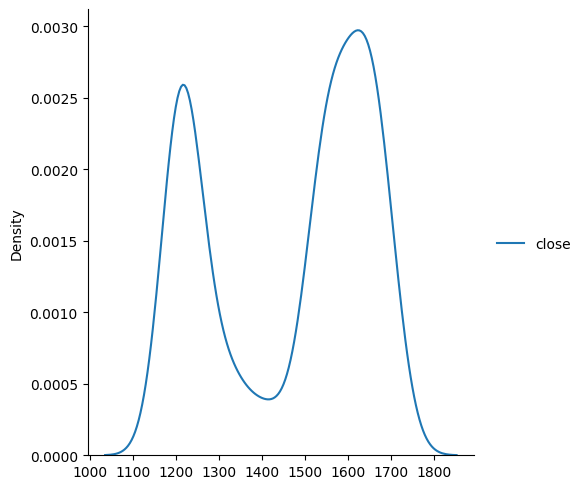

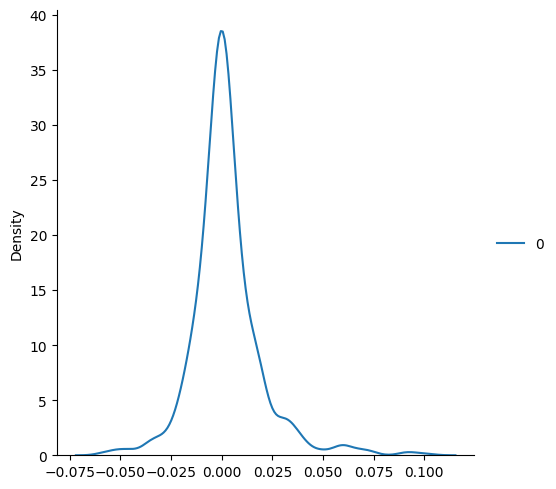

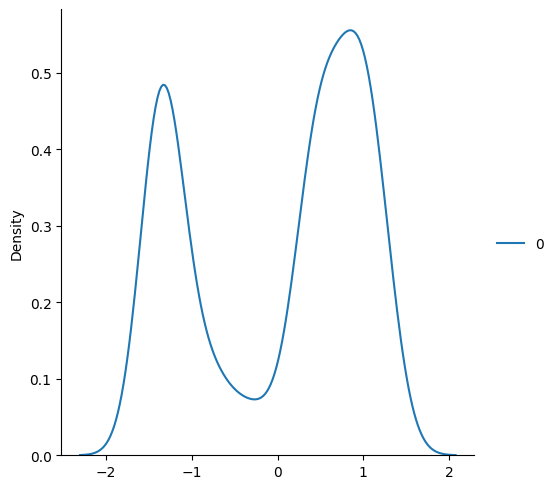

In [32]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
train_df = pd.DataFrame(train)
sns.displot(train_df, kind="kde")
sns.displot(pd.DataFrame(y_train), kind="kde")
scaler = StandardScaler()
scaler.fit(train_df)
sns.displot(scaler.transform(train_df), kind="kde")

In [97]:
model = build_lstm_model(X_train, neurons, dropout, optimizer)
history = model.fit(np.asarray(X_train).astype('float32'), np.asarray(y_train).astype('float32'), epochs = epochs, batch_size = batch_size, shuffle = True, callbacks = [early_stopping_callback, lr_scheduler_callback])

Epoch 1/10
49/50 [============================>.] - ETA: 0s - loss: 1.9301e-04

50/50 [==============================] - 4s 34ms/step - loss: 1.9095e-04 - lr: 0.0010
Epoch 2/10
49/50 [============================>.] - ETA: 0s - loss: 6.7185e-05

50/50 [==============================] - 2s 46ms/step - loss: 6.6884e-05 - lr: 0.0010
Epoch 3/10
49/50 [============================>.] - ETA: 0s - loss: 5.1600e-05

50/50 [==============================] - 1s 29ms/step - loss: 5.1520e-05 - lr: 0.0010
Epoch 4/10
49/50 [============================>.] - ETA: 0s - loss: 4.5351e-05

50/50 [==============================] - 1s 30ms/step - loss: 4.5298e-05 - lr: 0.0010
Epoch 5/10
49/50 [============================>.] - ETA: 0s - loss: 4.3259e-05

50/50 [==============================] - 1s 30ms/step - loss: 4.3092e-05 - lr: 0.0010
Epoch 6/10
49/50 [============================>.] - ETA: 0s - loss: 4.1153e-05

50/50 [==============================] - 1s 29ms/step - loss: 4.0927e-05 - lr: 0.0010
Epoch 7/10
49/50 [============================>.] - ETA: 0s - loss: 4.0058e-05

50/50 [==============================] - 1s 30ms/step - loss: 4.0431e-05 - lr: 0.0010
Epoch 8/10
49/50 [============================>.] - ETA: 0s - loss: 3.9226e-05

50/50 [==============================] - 2s 30ms/step - loss: 3.8840e-05 - lr: 0.0010
Epoch 9/10
49/50 [============================>.] - ETA: 0s - loss: 3.6156e-05

50/50 [==============================] - 2s 36ms/step - loss: 3.6233e-05 - lr: 0.0010
Epoch 10/10
50/50 [==============================] - ETA: 0s - loss: 3.5919e-05

50/50 [==============================] - 2s 44ms/step - loss: 3.5919e-05 - lr: 0.0010


13/13 [==============================] - 1s 10ms/step
 MSE: 3.922941585542382e-05


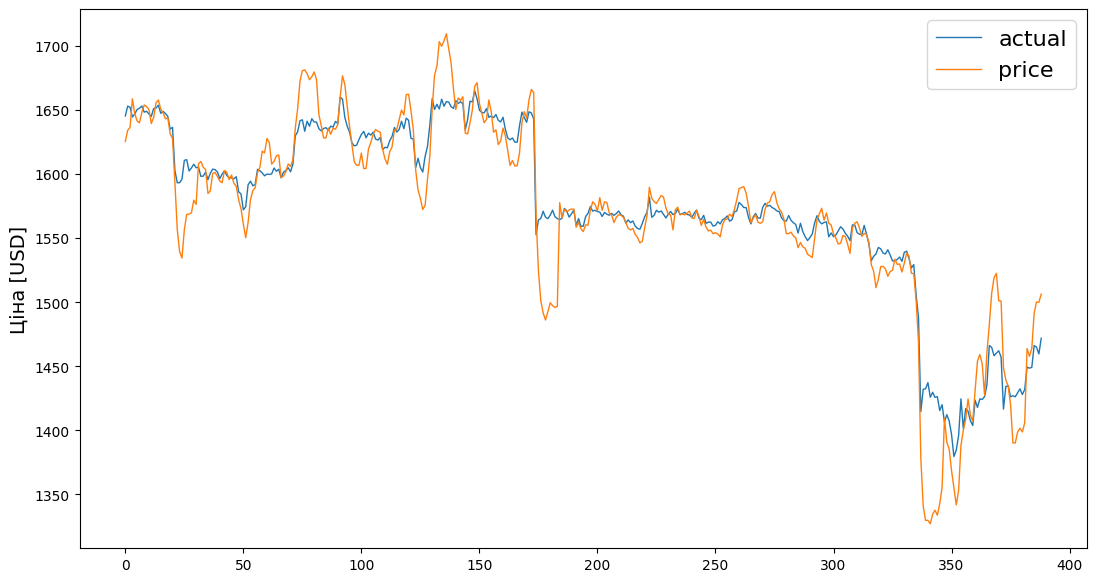

In [98]:
targets = test['close'][window_len:]
preds = model.predict(X_test).squeeze()
print(' MSE:', mean_squared_error(preds, y_test))
preds = test['close'].values[window_len:] * (preds + 1)
preds = pd.Series(index = targets.index, data = preds)
plot_result(targets.values, {'price': preds.values})

In [17]:
from sklearn.metrics import mean_absolute_error
print(' MAE:', mean_absolute_error(preds, y_test))

 MAE: 1568.9923298174704


In [18]:
data_props = {
'price': ['close'],
'historical': ['close', 'open', 'low', 'high', 'volume', 'trades_amount'],
'blockchain': ['max_value', 'average_amount', 'average_fee', 'average_gas_price', 'gas_used', 'transaction_amount'],
'twitter': ['positive', 'neutral']
}
data_sets = [['historical'], ['historical', 'blockchain'], ['historical',
'twitter'], ['historical', 'blockchain', 'twitter']]

targets = test['close'][window_len:]
results = {}
mse_results = {}
for item in data_sets[:4]:
  fields = []
  for field_type in item:
    fields.extend(data_props[field_type])

  df = merged_df[fields]
  train, test, X_train, X_test, y_train, y_test = prepare_data(df, window_len)
  current_model = build_lstm_model(X_train, neurons, dropout, optimizer)
  current_model.fit(np.asarray(X_train).astype('float32'), np.asarray(y_train).astype('float32'), epochs = epochs, batch_size = batch_size, shuffle = True, callbacks = [early_stopping_callback, lr_scheduler_callback])
  preds = current_model.predict(X_test).squeeze()
  key = ', '.join(item)
  mse_results[key] = mean_squared_error(preds, y_test)
  preds = test['close'][window_len:] * (preds + 1)
  preds = pd.Series(index = targets.index, data = preds)
  results[key] = preds.values

Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 0.0039

50/50 [==============================] - 6s 38ms/step - loss: 0.0039 - lr: 0.0010
Epoch 2/10
49/50 [============================>.] - ETA: 0s - loss: 8.9491e-04

50/50 [==============================] - 2s 30ms/step - loss: 8.9121e-04 - lr: 0.0010
Epoch 3/10
49/50 [============================>.] - ETA: 0s - loss: 6.2172e-04

50/50 [==============================] - 2s 31ms/step - loss: 6.1870e-04 - lr: 0.0010
Epoch 4/10
49/50 [============================>.] - ETA: 0s - loss: 5.2501e-04

50/50 [==============================] - 2s 30ms/step - loss: 5.2543e-04 - lr: 0.0010
Epoch 5/10
49/50 [============================>.] - ETA: 0s - loss: 5.4915e-04

50/50 [==============================] - 2s 31ms/step - loss: 5.4614e-04 - lr: 0.0010
Epoch 6/10
49/50 [============================>.] - ETA: 0s - loss: 3.8386e-04

50/50 [==============================] - 2s 30ms/step - loss: 3.8602e-04 - lr: 0.0010
Epoch 7/10
50/50 [==============================] - ETA: 0s - loss: 2.9514e-04

50/50 [==============================] - 2s 34ms/step - loss: 2.9514e-04 - lr: 0.0010
Epoch 8/10
49/50 [============================>.] - ETA: 0s - loss: 3.0075e-04

50/50 [==============================] - 2s 46ms/step - loss: 2.9787e-04 - lr: 0.0010
Epoch 9/10
49/50 [============================>.] - ETA: 0s - loss: 1.9164e-04

50/50 [==============================] - 2s 31ms/step - loss: 1.9327e-04 - lr: 0.0010
Epoch 10/10
49/50 [============================>.] - ETA: 0s - loss: 2.0959e-04

13/13 [==============================] - 1s 10ms/step
Epoch 1/10
49/50 [============================>.] - ETA: 0s - loss: 0.0175

50/50 [==============================] - 4s 31ms/step - loss: 0.0174 - lr: 0.0010
Epoch 2/10
49/50 [============================>.] - ETA: 0s - loss: 0.0056

50/50 [==============================] - 2s 44ms/step - loss: 0.0056 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 0.0038

50/50 [==============================] - 2s 36ms/step - loss: 0.0038 - lr: 0.0010
Epoch 4/10
49/50 [============================>.] - ETA: 0s - loss: 0.0036

50/50 [==============================] - 2s 30ms/step - loss: 0.0036 - lr: 0.0010
Epoch 5/10
49/50 [============================>.] - ETA: 0s - loss: 0.0028

50/50 [==============================] - 2s 31ms/step - loss: 0.0028 - lr: 0.0010
Epoch 6/10
50/50 [==============================] - ETA: 0s - loss: 0.0023

50/50 [==============================] - 2s 31ms/step - loss: 0.0023 - lr: 0.0010
Epoch 7/10
49/50 [============================>.] - ETA: 0s - loss: 0.0016

50/50 [==============================] - 2s 31ms/step - loss: 0.0015 - lr: 0.0010
Epoch 8/10
49/50 [============================>.] - ETA: 0s - loss: 0.0014

50/50 [==============================] - 2s 31ms/step - loss: 0.0015 - lr: 0.0010
Epoch 9/10
50/50 [==============================] - ETA: 0s - loss: 0.0012

50/50 [==============================] - 2s 33ms/step - loss: 0.0012 - lr: 0.0010
Epoch 10/10
50/50 [==============================] - ETA: 0s - loss: 8.3268e-04

13/13 [==============================] - 1s 8ms/step
Epoch 1/10
49/50 [============================>.] - ETA: 0s - loss: 0.0037

50/50 [==============================] - 4s 31ms/step - loss: 0.0037 - lr: 0.0010
Epoch 2/10
49/50 [============================>.] - ETA: 0s - loss: 0.0022

50/50 [==============================] - 2s 36ms/step - loss: 0.0022 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 0.0025

50/50 [==============================] - 2s 45ms/step - loss: 0.0025 - lr: 0.0010
Epoch 4/10
49/50 [============================>.] - ETA: 0s - loss: 0.0013

50/50 [==============================] - 2s 30ms/step - loss: 0.0014 - lr: 0.0010
Epoch 5/10
49/50 [============================>.] - ETA: 0s - loss: 0.0016

50/50 [==============================] - 2s 31ms/step - loss: 0.0016 - lr: 0.0010
Epoch 6/10
49/50 [============================>.] - ETA: 0s - loss: 0.0013

50/50 [==============================] - 2s 31ms/step - loss: 0.0013 - lr: 0.0010
Epoch 7/10
49/50 [============================>.] - ETA: 0s - loss: 0.0010

50/50 [==============================] - 2s 30ms/step - loss: 0.0010 - lr: 0.0010
Epoch 8/10
49/50 [============================>.] - ETA: 0s - loss: 9.5995e-04

50/50 [==============================] - 2s 30ms/step - loss: 9.4895e-04 - lr: 0.0010
Epoch 9/10
49/50 [============================>.] - ETA: 0s - loss: 7.7775e-04

50/50 [==============================] - 2s 31ms/step - loss: 7.6840e-04 - lr: 0.0010
Epoch 10/10
50/50 [==============================] - ETA: 0s - loss: 6.1906e-04

13/13 [==============================] - 1s 16ms/step
Epoch 1/10
49/50 [============================>.] - ETA: 0s - loss: 0.0161

50/50 [==============================] - 4s 30ms/step - loss: 0.0159 - lr: 0.0010
Epoch 2/10
49/50 [============================>.] - ETA: 0s - loss: 0.0068

50/50 [==============================] - 2s 31ms/step - loss: 0.0067 - lr: 0.0010
Epoch 3/10
49/50 [============================>.] - ETA: 0s - loss: 0.0057

50/50 [==============================] - 2s 31ms/step - loss: 0.0056 - lr: 0.0010
Epoch 4/10
49/50 [============================>.] - ETA: 0s - loss: 0.0038

50/50 [==============================] - 2s 41ms/step - loss: 0.0038 - lr: 0.0010
Epoch 5/10
49/50 [============================>.] - ETA: 0s - loss: 0.0034

50/50 [==============================] - 2s 41ms/step - loss: 0.0034 - lr: 0.0010
Epoch 6/10
49/50 [============================>.] - ETA: 0s - loss: 0.0022

50/50 [==============================] - 2s 31ms/step - loss: 0.0022 - lr: 0.0010
Epoch 7/10
49/50 [============================>.] - ETA: 0s - loss: 0.0022

50/50 [==============================] - 2s 31ms/step - loss: 0.0021 - lr: 0.0010
Epoch 8/10
49/50 [============================>.] - ETA: 0s - loss: 0.0024

50/50 [==============================] - 2s 31ms/step - loss: 0.0026 - lr: 0.0010
Epoch 9/10
49/50 [============================>.] - ETA: 0s - loss: 0.0018

50/50 [==============================] - 2s 31ms/step - loss: 0.0018 - lr: 0.0010
Epoch 10/10
49/50 [============================>.] - ETA: 0s - loss: 0.0013

13/13 [==============================] - 1s 9ms/step


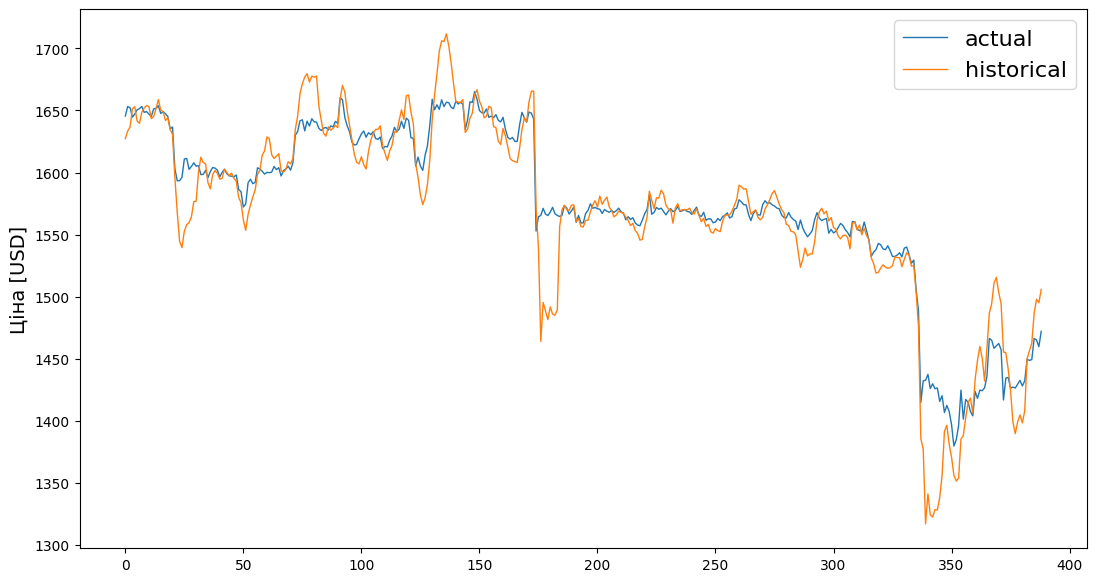

In [19]:
plot_result(targets.values, results)

In [20]:
rating = sorted(mse_results.items(), key = lambda x: x[1])
for item in rating:
  print(item[0], '-', item[1])

historical - 5.6073449142571825e-05
historical, blockchain - 0.00017427889881201558
historical, twitter - 0.00021676585909112281
historical, blockchain, twitter - 0.0002712944654165693


Якщо зважати на середню квадратичну помилку, то комбінація historical, twitter дає найкращий результат,

## Bitcoin

In [91]:
df = pd.read_csv('https://raw.githubusercontent.com/Vidzhel/data-analysis/main/bitcoin.csv', sep=',')

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         10000 non-null  int64  
 1   Timestamp          10000 non-null  int64  
 2   Open               10000 non-null  float64
 3   High               10000 non-null  float64
 4   Low                10000 non-null  float64
 5   close              10000 non-null  float64
 6   Volume_(BTC)       10000 non-null  float64
 7   Volume_(Currency)  10000 non-null  float64
 8   Weighted_Price     10000 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 703.2 KB


In [93]:
df.describe()

,Unnamed: 0,Timestamp,Open,High,Low,close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,231161.315500,1.339188e+09,7.436651,7.440225,7.432439,7.435966,20.461003,149.852163,7.436461
std,88443.786251,5.306627e+06,2.553450,2.556626,2.548851,2.551795,58.111951,423.988937,2.553138
min,0.000000,1.325318e+09,3.800000,3.800000,3.800000,3.800000,0.000000,0.000000,3.800000
25%,178732.500000,1.336042e+09,5.190000,5.190000,5.190000,5.190000,2.000000,12.629405,5.190000
50%,257916.500000,1.340793e+09,6.540000,6.550000,6.540000,6.540000,6.428862,44.757569,6.540000
75%,299829.750000,1.343308e+09,8.860000,8.860000,8.852500,8.860000,19.990000,137.369726,8.860000
max,334299.000000,1.345376e+09,16.410000,16.410000,15.490000,16.000000,2285.000000,14852.500000,16.386568


In [94]:
targets = test['close'][window_len:]
working_df = df[['close', 'Open', 'Low', 'High', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price']]
train, test, X_train, X_test, y_train, y_test = prepare_data(working_df, window_len)
current_model = build_lstm_model(X_train, neurons, dropout, optimizer)
current_model.fit(np.asarray(X_train).astype('float32'), np.asarray(y_train).astype('float32'), epochs = epochs, batch_size = batch_size, shuffle = True, callbacks = [early_stopping_callback, lr_scheduler_callback])


Epoch 1/10
250/250 [==============================] - ETA: 0s - loss: 0.0102

250/250 [==============================] - 11s 35ms/step - loss: 0.0102 - lr: 0.0010
Epoch 2/10
249/250 [============================>.] - ETA: 0s - loss: 0.0022

250/250 [==============================] - 9s 34ms/step - loss: 0.0022 - lr: 0.0010
Epoch 3/10
249/250 [============================>.] - ETA: 0s - loss: 8.9509e-04

250/250 [==============================] - 7s 30ms/step - loss: 8.9399e-04 - lr: 0.0010
Epoch 4/10
250/250 [==============================] - ETA: 0s - loss: 5.0482e-04

250/250 [==============================] - 9s 34ms/step - loss: 5.0482e-04 - lr: 0.0010
Epoch 5/10
250/250 [==============================] - ETA: 0s - loss: 4.0012e-04

250/250 [==============================] - 10s 40ms/step - loss: 4.0012e-04 - lr: 0.0010
Epoch 6/10
250/250 [==============================] - ETA: 0s - loss: 3.3071e-04

250/250 [==============================] - 9s 37ms/step - loss: 3.3071e-04 - lr: 0.0010
Epoch 7/10
249/250 [============================>.] - ETA: 0s - loss: 3.0968e-04

250/250 [==============================] - 9s 34ms/step - loss: 3.0912e-04 - lr: 0.0010
Epoch 8/10
249/250 [============================>.] - ETA: 0s - loss: 2.7495e-04

250/250 [==============================] - 8s 34ms/step - loss: 2.7437e-04 - lr: 0.0010
Epoch 9/10
249/250 [============================>.] - ETA: 0s - loss: 2.6083e-04

250/250 [==============================] - 8s 30ms/step - loss: 2.6026e-04 - lr: 0.0010
Epoch 10/10
249/250 [============================>.] - ETA: 0s - loss: 2.6935e-04

250/250 [==============================] - 9s 34ms/step - loss: 2.6915e-04 - lr: 0.0010


63/63 [==============================] - 1s 10ms/step
 MSE: 0.00022946680827523673


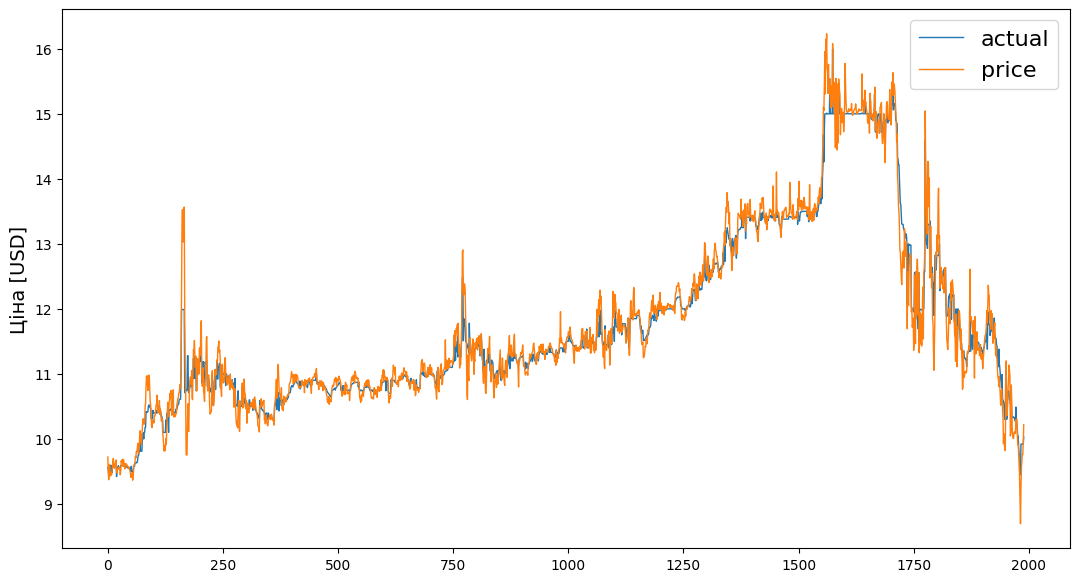

In [95]:
preds = current_model.predict(X_test).squeeze()
print(' MSE:', mean_squared_error(preds, y_test))
preds = test['close'].values[window_len:] * (preds + 1)
preds = pd.Series(index = targets.index, data = preds)
plot_result(targets.values, {'price': preds.values})